## Imports

In [1]:
import copy
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from config import config
import os
import sys
current_dir = os.getcwd()
path = "C:\\Users\\eirik\\Documents\\Master\\ISLBBNN\\islbbnn"
# path = "C:\\you\\path\\to\\islbbnn\\folder\\here"
os.chdir(path)
import plot_functions as pf
import pipeline_functions as pip_func
sys.path.append('networks')
from flow_net import BayesianNetwork
import torch.nn.functional as F

os.chdir(current_dir) # set the working directory back to this one 

CPUs are used!


# Problem description

Consits of 1095 datapoints, 77 proteins, and 7 different classes to predict. 

Classes:

* c-CS-s: control mice, stimulated to learn, injected with saline (9 mice)
* c-CS-m: control mice, stimulated to learn, injected with memantine (10 mice)
* c-SC-s: control mice, not stimulated to learn, injected with saline (9 mice)
* c-SC-m: control mice, not stimulated to learn, injected with memantine (10 mice)
* t-CS-s: trisomy mice, stimulated to learn, injected with saline (7 mice)
* t-CS-m: trisomy mice, stimulated to learn, injected with memantine (9 mice)
* t-SC-s: trisomy mice, not stimulated to learn, injected with saline (9 mice)
* t-SC-m: trisomy mice, not stimulated to learn, injected with memantine (9 mice)

Attained from this website: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0129126

# Batch size and parameters

In [2]:
# define parameters
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
post_train_epochs = config['post_train_epochs']
dim = config['hidden_dim']
num_transforms = config['num_transforms']
n_nets = config['n_nets']
lr = config['lr']
class_problem = config["class_problem"]
verbose = config['verbose']
save_res = config['save_res']
patience = config['patience']
a_prior = config['a_prior']
SAMPLES = 1



#---------DATA------------
df = pd.read_excel("Data_Cortex_Nuclear.xlsx")
X_pd = df.iloc[:,1:-4]
X_pd.fillna(X_pd.mean(),inplace=True)
X_original = X_pd.values
target = df.values[:, -1]
n, p = X_original.shape  # need this to get p 
y_original = np.zeros(len(target))
labeling = {}
for i, val in enumerate(np.unique(target)):
    labeling[i] = val
    y_original[target==val] = i

print(n,p)
print(labeling)

n_classes = len(labeling)
multiclass = n_classes > 1

BATCH_SIZE = int(n*0.8)
TEST_BATCH_SIZE = int(n*0.10) # Would normally call this the "validation" part (will be used during training)
VAL_BATCH_SIZE = int(n*0.10) # and this the "test" part (will be used after training)

TRAIN_SIZE = int(n*0.80)
TEST_SIZE = int(n*0.10) # Would normally call this the "validation" part (will be used during training)
VAL_SIZE = int(n*0.10) # and this the "test" part (will be used after training)

NUM_BATCHES = TRAIN_SIZE/BATCH_SIZE

assert (TRAIN_SIZE % BATCH_SIZE) == 0
assert (TEST_SIZE % TEST_BATCH_SIZE) == 0

1095 77
{0: 'c-CS-m', 1: 'c-CS-s', 2: 'c-SC-m', 3: 'c-SC-s', 4: 't-CS-m', 5: 't-CS-s', 6: 't-SC-m', 7: 't-SC-s'}


c:\Users\eirik\miniconda3\envs\master\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


# Sigmoid based network

## Seperate a test set for later

In [3]:
# Split keep some of the data for validation after training
X, X_test, y, y_test = train_test_split(
    copy.deepcopy(X_original), copy.deepcopy(y_original), test_size=0.10, random_state=42, stratify=y_original)

scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

test_dat = torch.tensor(np.column_stack((X_test,y_test)),dtype = torch.float32)

## Train, validate, and test network

In [ ]:
# select the device and initiate model

# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

all_nets = {}
metrics_several_runs = []
metrics_median_several_runs = []
for ni in range(n_nets):
    post_train = False
    print('network', ni)
    # Initate network
    torch.manual_seed(ni+42)
    net = BayesianNetwork(dim, p, HIDDEN_LAYERS, classification=class_problem, num_transforms=num_transforms, a_prior=a_prior, n_classes=n_classes).to(DEVICE)
    alphas = pip_func.get_alphas_numpy(net)
    nr_weights = np.sum([np.prod(a.shape) for a in alphas])
    print(nr_weights)

    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    all_nll = []
    all_loss = []

    # Split into training and test set
    X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=1/9, random_state=ni)#, stratify=y)
            
    train_dat = torch.tensor(np.column_stack((X_train,y_train)),dtype = torch.float32)
    val_dat = torch.tensor(np.column_stack((X_val,y_val)),dtype = torch.float32)
    
    # Train network
    counter = 0
    highest_acc = 0
    best_model = copy.deepcopy(net)
    for epoch in range(epochs + post_train_epochs):
        if verbose:
            print(epoch)
        nll, loss = pip_func.train(net, train_dat, optimizer, BATCH_SIZE, NUM_BATCHES, p, DEVICE, nr_weights, post_train=post_train, multiclass=multiclass)
        nll_val, loss_val, ensemble_val = pip_func.val(net, val_dat, DEVICE, verbose=verbose, reg=(not class_problem), post_train=post_train, multiclass=multiclass)
        if ensemble_val >= highest_acc:
            counter = 0
            highest_acc = ensemble_val
            best_model = copy.deepcopy(net)
        else:
            counter += 1
        
        all_nll.append(nll)
        all_loss.append(loss)

        if epoch == epochs-1:
            post_train = True   # Post-train --> use median model 
            for name, param in net.named_parameters():
                for i in range(HIDDEN_LAYERS+1):
                    #if f"linears{i}.lambdal" in name:
                    if f"linears.{i}.lambdal" in name:
                        param.requires_grad_(False)

        if counter >= patience:
            break
        
    all_nets[ni] = net 
    # Results
    metrics, metrics_median = pip_func.test_ensemble(all_nets[ni],test_dat,DEVICE,SAMPLES=10, reg=(not class_problem), multiclass=multiclass) # Test same data 10 times to get average 
    metrics_several_runs.append(metrics)
    metrics_median_several_runs.append(metrics_median)
    pf.run_path_graph(all_nets[ni], threshold=0.5, save_path=f"path_graphs/flow/prob/test{ni}_sigmoid", show=verbose)

if verbose:
    print(metrics)
m = np.array(metrics_several_runs)
m_median = np.array(metrics_median_several_runs)

<img src="path_graphs/flow/prob/test0_sigmoid.png" />

After training:

* 91 weights used in median model $\rightarrow$ density of 0.8\% compared to initialized model (11'216 weigths) 
* ACC of 90\% for median model
* ACC of 14\% for full model

## Attain weigth graph

In [5]:
pf.run_path_graph_weight(net, save_path="path_graphs/flow/weight/temp_sigmoid", show=True, flow=True)

<img src="path_graphs/flow/weight/temp_sigmoid.png" />

## Individual paths for each class

In [6]:
pf.plot_path_individual_classes(net, n_classes)

Used weights:  8
Used weights:  12
Used weights:  9
Used weights:  17
Used weights:  13
Used weights:  11
Used weights:  14
Used weights:  7


# ReLU based network

## Seperate a test set for later

In [7]:
# Split keep some of the data for validation after training
X, X_test, y, y_test = train_test_split(
    copy.deepcopy(X_original), copy.deepcopy(y_original), test_size=0.10, random_state=42, stratify=y_original)

scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

test_dat = torch.tensor(np.column_stack((X_test,y_test)),dtype = torch.float32)

## Train, validate, and test network

In [ ]:
# select the device and initiate model

# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

all_nets = {}
metrics_several_runs = []
metrics_median_several_runs = []
for ni in range(n_nets):
    post_train = False
    print('network', ni)
    # Initate network
    torch.manual_seed(ni+42)
    #---------------------------
    # DIFFERENCE IS IN act_func=F.relu part
    net = BayesianNetwork(dim, p, HIDDEN_LAYERS, classification=class_problem, num_transforms=num_transforms, act_func=F.relu, a_prior=a_prior, n_classes=n_classes).to(DEVICE)
    #---------------------------
    alphas = pip_func.get_alphas_numpy(net)
    nr_weights = np.sum([np.prod(a.shape) for a in alphas])
    print(nr_weights)

    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    all_nll = []
    all_loss = []

    # Split into training and test set
    X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=1/9, random_state=ni)#, stratify=y)
            
    train_dat = torch.tensor(np.column_stack((X_train,y_train)),dtype = torch.float32)
    val_dat = torch.tensor(np.column_stack((X_val,y_val)),dtype = torch.float32)
    
    # Train network
    counter = 0
    highest_acc = 0
    best_model = copy.deepcopy(net)
    for epoch in range(epochs + post_train_epochs):
        if verbose:
            print(epoch)
        nll, loss = pip_func.train(net, train_dat, optimizer, BATCH_SIZE, NUM_BATCHES, p, DEVICE, nr_weights, post_train=post_train, multiclass=multiclass)
        nll_val, loss_val, ensemble_val = pip_func.val(net, val_dat, DEVICE, verbose=verbose, reg=(not class_problem), post_train=post_train, multiclass=multiclass)
        if ensemble_val >= highest_acc:
            counter = 0
            highest_acc = ensemble_val
            best_model = copy.deepcopy(net)
        else:
            counter += 1
        
        all_nll.append(nll)
        all_loss.append(loss)

        if epoch == epochs-1:
            post_train = True   # Post-train --> use median model 
            for name, param in net.named_parameters():
                for i in range(HIDDEN_LAYERS+1):
                    #if f"linears{i}.lambdal" in name:
                    if f"linears.{i}.lambdal" in name:
                        param.requires_grad_(False)

        if counter >= patience:
            break
        
    all_nets[ni] = net 
    # Results
    metrics, metrics_median = pip_func.test_ensemble(all_nets[ni],test_dat,DEVICE,SAMPLES=10, reg=(not class_problem), multiclass=multiclass) # Test same data 10 times to get average 
    metrics_several_runs.append(metrics)
    metrics_median_several_runs.append(metrics_median)
    pf.run_path_graph(all_nets[ni], threshold=0.5, save_path=f"path_graphs/flow/prob/test{ni}_relu", show=verbose)

if verbose:
    print(metrics)
m = np.array(metrics_several_runs)
m_median = np.array(metrics_median_several_runs)

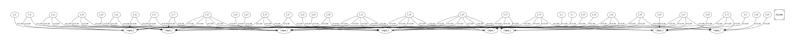

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread("path_graphs/flow/prob/test0_relu.png")
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img)
plt.show()

After training:

* 79 weights used in median model $\rightarrow$ density of 0.7\% compared to initialized model (11'216 weigths) 
* ACC of 85\% for median model
* ACC of 12\% for full model

## Attain weight graph

In [9]:
pf.run_path_graph_weight(net, save_path="path_graphs/flow/weight/temp_relu", show=True, flow=True)

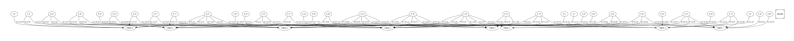

In [15]:
img = mpimg.imread("path_graphs/flow/weight/temp_relu.png")
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img)
plt.show()

## Individual paths

In [10]:
pf.plot_path_individual_classes(net, n_classes)

Used weights:  9
Used weights:  11
Used weights:  7
Used weights:  12
Used weights:  9
Used weights:  13
Used weights:  12
Used weights:  6


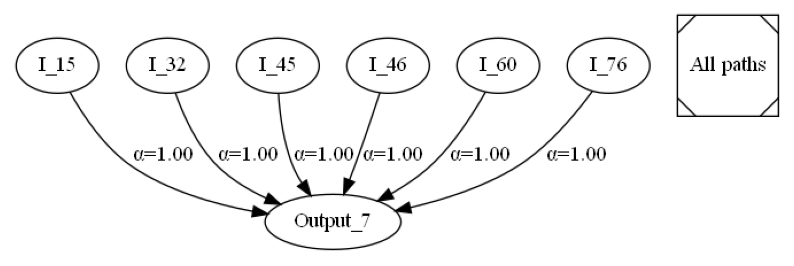

In [12]:
img = mpimg.imread("individual_classes/class7.png")
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img)
plt.show()